## CNN 的实现
我们已经实现了卷积层和池化层，现在来组合这些层，搭建进行手写数字识别的CNN。这里要实现如图7-23所示的 CNN。

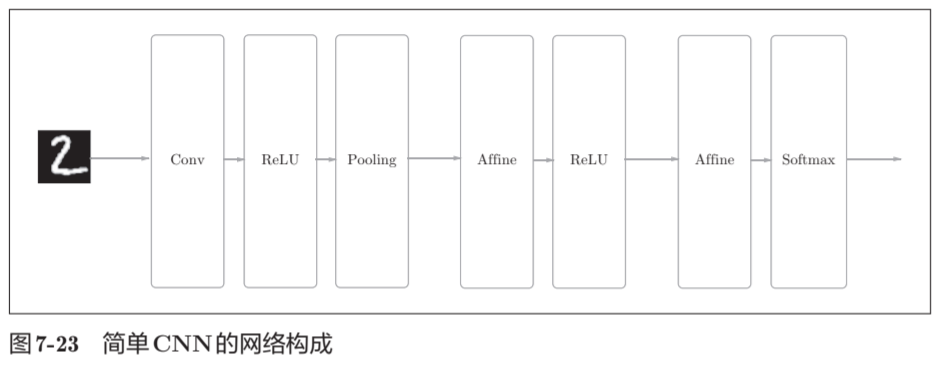

如图7-23所示，网络的构成是“Convolution - ReLU - Pooling -Affine - ReLU - Affine - Softmax”，我们将它实现为名为 SimpleConvNet 的类。


首先来看一下 SimpleConvNet 的初始化（\__init__），取下面这些参数。

**参数**
* input_dim ― 输入数据的维度：（通道，高，长）
* conv_param ― 卷积层的超参数（字典）。字典的关键字如下：<br>filter_num―滤波器的数量<br>filter_size―滤波器的大小<br>stride―步幅<br>pad―填充
* hidden_size ― 隐藏层（全连接）的神经元数量
* output_size ― 输出层（全连接）的神经元数量
* weitght_int_std ― 初始化时权重的标准差

这里，卷积层的超参数通过名为 conv_param 的字典传入。<br>
我们设想它会像 {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1} 这样，保存必要的超参数值。

SimpleConvNet 的初始化的实现稍长。

In [5]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
        # 初始化的最开始部分
        # 这里将由初始化参数传入的卷积层的超参数从字典中取了出来（以方便后面使用），然后，计算卷积层的输出大小
        conv_param={'filter_num':30, 'filter_size':5,'pad':0, 'stride':1},
        hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 权重参数的初始化部分
        # 学习所需的参数是第1层的卷积层和剩余两个全连接层的权重和偏置
        # 将这些参数保存在实例变量的params字典中
        # 将第1层的卷积层的权重设为关键字W1，偏置设为关键字b1
        # 同样，分别用关键字W2、b2和关键字W3、b3来保存第2个和第3个全连接层的权重和偏置
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # 生成必要的层
        # 从最前面开始按顺序向有序字典（OrderedDict）的layers中添加层
        # 只有最后的SoftmaxWithLoss层被添加到别的变量lastLayer中
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'],
        conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'],
        self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
        self.params['b3'])
        self.last_layer = softmaxwithloss()
        
        # 以上就是 SimpleConvNet 的初始化中进行的处理
        # 像这样初始化后，进行推理的predict方法和求损失函数值的loss方法就可以像下面这样实现
        # 这里，参数x是输入数据，t是教师标签
        # 用于推理的predict方法从头开始依次调用已添加的层，并将结果传递给下一层
        # 在求损失函数的loss方法中，除了使用predict方法进行的 forward处理之外，
        # 还会继续进行forward处理，直到到达最后的SoftmaxWithLoss层
        def predict(self, x):
            for layer in self.layers.values():
                x = layer.forward(x)
            return x
        def loss(self, x, t):
            y = self.predict(x)
            return self.lastLayer.forward(y, t)
        
        # 接下来是基于误差反向传播法求梯度的代码实现
        # 参数的梯度通过误差反向传播法（反向传播）求出，通过把正向传播和反向传播组装在一起来完成
        # 因为已经在各层正确实现了正向传播和反向传播的功能，所以这里只需要以合适的顺序调用即可。
        # 最后，把各个权重参数的梯度保存到grads字典中
        def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 设定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads

IndentationError: expected an indented block (<ipython-input-5-ec38c9483ffe>, line 63)

如果使用 MNIST数据集 训练 SimpleConvNet ，则训练数据的识别率为99.82%，测试数据的识别率为98.96%（每次学习的识别精度都会发生一些误差）。<br>

测试数据的识别率大约为99%，就小型网络来说，这是一个非常高的识别率。<br>

下一章，我们会通过进一步叠加层来加深网络，实现测试数据的识别率超过99%的网络。<br>

如上所述，卷积层和池化层是图像识别中必备的模块。<br>

CNN 可以有效读取图像中的某种特性，在手写数字识别中，还可以实现高精度的识别。<br>